## Homework 4

SYS 6018: Machine Learning

Caitlin Dreisbach (CND2y)

Elizabeth Homan Harrsion (EIH2NN)

Morgan Wall (MKY2K)


In [1]:
# Load libraries
import tensorflow as tf
import cv2
import random
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Basic Functions:
def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x,name):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME',name=name)
 

def weight_variable(shape,varname):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=varname)


def bias_variable(shape,varname):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=varname)

In [3]:
# Build ConvNet
def deepnn(x):
    # x is 64x64x3
    
    # First Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([5, 5, 3, 16],'conv_w')
        b_conv1 = bias_variable([16],'conv_b')
        h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1,name='h_conv_op')
        h_pool1 = max_pool_2x2(h_conv1,'h_pool_op')
    # output: 32x32x16
 
    # Second Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([5, 5, 16, 16],'conv_w')
        b_conv2 = bias_variable([16],'conv_b')
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2,name='h_conv_op')
        h_pool2 = max_pool_2x2(h_conv2,'h_pool_op')
    # output: 16x16x16

    # Third Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([5, 5, 16, 32],'conv_w')
        b_conv3 = bias_variable([32],'conv_b')
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3,name='h_conv_op')
        h_pool3 = max_pool_2x2(h_conv3,'h_pool_op')
    # output: 8x8x32

    # First Fully Connected Layer
    with tf.name_scope('fc'):
        # Flatten output from previous layer
        h_pool3_flat = tf.reshape(h_pool3, [-1, 8*8*32])
        # Fully connected + Relu
        # input: flat (8x8x32) = 1x2048
        W_fc1 = weight_variable([8 * 8* 32, 1024],'fc_w')
        b_fc1 = bias_variable([1024],'fc_b')
        h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
    # output: 1x1024
    
    # Dropout
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32,name="keep_prob")
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Output Softmax Layer: Map the 1024 features to 2 classes, one for each class type
    with tf.name_scope('sm'):
        W_sm = weight_variable([1024, 2],'sm_w')
        b_sm = bias_variable([2],'sm_b')
        y_conv_out = tf.add(tf.matmul(h_fc1_drop, W_sm), b_sm, name="y_conv_op")
 
    return y_conv_out,keep_prob

In [4]:
# Extra functions:
# DataSet class to handle images 
class DataSet(object):
    def __init__(self, images, labels):
        self._num_examples = len(images)
        self._images = images
        self._labels = labels
        self._epochs_done = 0
        self._index_in_epoch = 0
        np.random.seed(123456)
        # Shuffle the data
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._images = self._images[perm]
        self._labels = self._labels[perm]
        random.seed(123456)
    @property
    def images(self):
        return self._images
    @property
    def labels(self):
        return self._labels
    @property
    def num_examples(self):
        return self._num_examples
    @property
    def epochs_done(self):
        return self._epochs_done
    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # After each epoch we update this
            self._epochs_done += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm] 
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
    
        return self._images[start:end], self._labels[start:end]

# read images from a directory
def read_images(path,images,labels,class_num,class_index):
    files = glob.glob(os.path.join(path, '*g'))
    for fl in files:
        image = cv2.imread(fl)
        image = image.astype(np.float32)
        image = np.multiply(image, 1.0 / 255.0)
        images.append(image)
        label = np.zeros(class_num)
        label[class_index] = 1.0
        labels.append(label)
    return images,labels

## Reading in image data from sub-directories

In [18]:
def read_images_from_disk(input_queue):
    """Consumes a single filename and label as a ' '-delimited string.
    Args:
      filename_and_label_tensor: A scalar string tensor.
    Returns:
      Two tensors: the decoded image, and the string label.
    """
    label = input_queue[1]
    file_contents = tf.read_file(input_queue[0])
    example = tf.image.decode_png(file_contents, channels=3)
    return example, label

In [24]:
#get labeled directories into a list
directory_list = list()
for root, dirs, files in os.walk("/Users/caitdreisbach/Downloads/imagesML/train", topdown=False):
    for name in dirs:
        directory_list.append(os.path.join(root, name))

print(directory_list)

['/Users/caitdreisbach/Downloads/imagesML/train/contempt', '/Users/caitdreisbach/Downloads/imagesML/train/fear', '/Users/caitdreisbach/Downloads/imagesML/train/surprise', '/Users/caitdreisbach/Downloads/imagesML/train/sadness', '/Users/caitdreisbach/Downloads/imagesML/train/neutral', '/Users/caitdreisbach/Downloads/imagesML/train/happiness', '/Users/caitdreisbach/Downloads/imagesML/train/anger', '/Users/caitdreisbach/Downloads/imagesML/train/disgust']


In [34]:
#remove path prior to file name
import ntpath
ntpath.basename("/Users/caitdreisbach/Downloads/imagesML/train/")

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

paths = ['/Users/caitdreisbach/Downloads/imagesML/train/contempt', 
         '/Users/caitdreisbach/Downloads/imagesML/train/fear', 
         '/Users/caitdreisbach/Downloads/imagesML/train/surprise', 
         '/Users/caitdreisbach/Downloads/imagesML/train/sadness', 
         '/Users/caitdreisbach/Downloads/imagesML/train/neutral', 
         '/Users/caitdreisbach/Downloads/imagesML/train/happiness', 
         '/Users/caitdreisbach/Downloads/imagesML/train/anger', 
         '/Users/caitdreisbach/Downloads/imagesML/train/disgust']
labels = [path_leaf(path) for path in paths]

In [35]:
print(labels)

['contempt', 'fear', 'surprise', 'sadness', 'neutral', 'happiness', 'anger', 'disgust']


Reading images
['/Users/caitdreisbach/Downloads/imagesML/train/contempt', '/Users/caitdreisbach/Downloads/imagesML/train/fear', '/Users/caitdreisbach/Downloads/imagesML/train/surprise', '/Users/caitdreisbach/Downloads/imagesML/train/sadness', '/Users/caitdreisbach/Downloads/imagesML/train/neutral', '/Users/caitdreisbach/Downloads/imagesML/train/happiness', '/Users/caitdreisbach/Downloads/imagesML/train/anger', '/Users/caitdreisbach/Downloads/imagesML/train/disgust']
Finished reading images


IndexError: index 0 is out of bounds for axis 0 with size 0

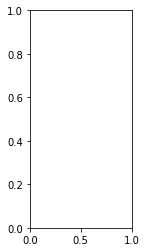

In [23]:
import os

# load images
images = []
labels = []

print('Reading images')

#images,labels=read_images('/Users/caitdreisbach/Downloads/imagesML/train',images,labels,2,0)
rootDir = '/Users/caitdreisbach/Downloads/imagesML/train'

#get labeled directories into a list
directory_list = list()
for root, dirs, files in os.walk("/Users/caitdreisbach/Downloads/imagesML/train", topdown=False):
    for name in dirs:
        directory_list.append(os.path.join(root, name))

print(directory_list)

# traverse root directory, and list directories as dirs and files as files
#for root, dirs, files in os.walk(rootDir):
#    path = root.split(os.sep)
#    print((len(path) - 1) * '---', os.path.basename(root))
#    for file in files:
#        print(len(path) * '---', file)
        
        
print('Finished reading images') 

images = np.array(images)
labels = np.array(labels)

# Create dataset
train = DataSet(images, labels)

# parameters
model_dir="model_MonaLisa"
max_itr=1000
image_size=64

# Inspect Data: Show first image of each type
fig = plt.figure(figsize=(4, 4)) 

ax = fig.add_subplot(121)
plt.imshow(images[0])
ax.set_title('Faces')  

plt.show()

## Create computational graph 

In [6]:
# ******** Cell - 1 ***********
graph = tf.Graph()
with graph.as_default():   
    # Create the computational graph:
    # Placeholders:
    x = tf.placeholder(tf.float32, [None, image_size,image_size,3],name="x")
    y = tf.placeholder(tf.float32, [None, 2],name="y")
        
    # Build the graph for the deep net
    y_conv_out,keep_prob = deepnn(x)
    
    # Add loss, accuracy and optimization
    probs=tf.nn.softmax(logits=y_conv_out, name="probs_op")
    
    with tf.name_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=y_conv_out)
        cross_entropy = tf.reduce_mean(cross_entropy)
    
    with tf.name_scope('adam_optimizer'):
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv_out, 1), tf.argmax(y, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction, name="acc_op")
        
    # Add a saver to save the trained model
    saver = tf.train.Saver() 

AttributeError: module 'tensorflow.python.ops.nn' has no attribute 'softmax_cross_entropy_with_logits_v2'

In [ ]:
# ******** Cell - 2 ***********
# Reset graph: useful for multiple runs (e.g., parameter tuning, CV, etc.)
tf.reset_default_graph()  
# Create session to execute graph
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(max_itr):
        # Save a version of the model every 100 iterations
        if i>0 and i%100==0:
            saver.save(sess, "./%s/model"%(model_dir), global_step=i)
            
        # Get a batch of 32 images    
        x_batch, y_true_batch = train.next_batch(32) 
        
        # Get training accuracy on the batch
        if i>0 and i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: x_batch , y: y_true_batch, keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
            
        # Train
        train_step.run(feed_dict={x: x_batch, y: y_true_batch, keep_prob: 0.5})
    
    # save final model
    save_path = saver.save(sess, "./%s/model"%(model_dir), global_step=max_itr)
    print("Model saved in file: %s" % save_path)
    
    # Get training accuracy on all training images
    train_accuracy=accuracy.eval(feed_dict={x: images,y: labels, keep_prob: 1.0 })
    print ("Training Accuracy: %10.5f"%train_accuracy)

In [ ]:
# Load testing images
test_images = []   
test_labels = []   

print('Reading testing images')
test_images,test_labels=read_images('jellyfish_valid',test_images,test_labels,2,0)
test_images,test_labels=read_images('bullfrog_valid',test_images,test_labels,2,1)
print('Finished reading testing images') 

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
# ******** Cell - 3 ***********
# Test model on testing data
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('./%s/model-%s.meta'%(model_dir,max_itr))
    saver.restore(sess,tf.train.latest_checkpoint(model_dir))
    graph = tf.get_default_graph()
    
    #print([n.name for n in tf.get_default_graph().as_graph_def().node])
     
    x = graph.get_tensor_by_name("x:0")
    y = graph.get_tensor_by_name("y:0")
    keep_prob= graph.get_tensor_by_name("dropout/keep_prob:0") 
    accuracy = graph.get_tensor_by_name("accuracy/acc_op:0")
    
    acc_val=accuracy.eval(feed_dict={x: test_images,y: test_labels, keep_prob: 1.0 })
    
    print ("Testing Accuracy: %10.5f"%acc_val)

## Part 2 (more challenging): Bull Frog VS. Tailed Frog

In [ ]:
# load images
images = []
labels = []

print('Reading images')
images,labels=read_images('tailed frog_train/images',images,labels,2,0)
images,labels=read_images('bullfrog_train/images',images,labels,2,1)
print('Finished reading images')

# Create dataset
train = DataSet(np.array(images), np.array(labels))

# parameters
model_dir="model_bull_tailed_frog"
max_itr=1000
image_size=64

# Inspect Data: Show first image of each type
fig = plt.figure(figsize=(4, 4)) 

ax = fig.add_subplot(121)
plt.imshow(images[0])
ax.set_title('Tailed Frog')  

ax = fig.add_subplot(122)
plt.imshow(images[501])
ax.set_title('Bull Frog')

plt.show()

### Run Cells 1 and 2

In [ ]:
# Load testing images and test model
test_images=[]
test_labels=[]
print('Reading images')
test_images,test_labels=read_images('tailed frog_valid',test_images,test_labels,2,0)
test_images,test_labels=read_images('bullfrog_valid',test_images,test_labels,2,1)
print('Finished reading images') 
test_images = np.array(test_images)
test_labels = np.array(test_labels)

### Run Cell 3

In [ ]:
# Try to improve our ConvNet model
# Approach: Try larger filters, more filters & Train for more iterations
max_itr = 3000
def deepnn(x):
    # x is 64x64x3
    
    # First Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([11, 11, 3, 16],'conv_w')
        b_conv1 = bias_variable([16],'conv_b')
        h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1,name='h_conv_op')
        h_pool1 = max_pool_2x2(h_conv1,'h_pool_op')
    # output: 32x32x16
 
    # Second Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([11, 11, 16, 32],'conv_w')
        b_conv2 = bias_variable([32],'conv_b')
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2,name='h_conv_op')
        h_pool2 = max_pool_2x2(h_conv2,'h_pool_op')
    # output: 16x16x16

    # Third Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([5, 5, 32, 64],'conv_w')
        b_conv3 = bias_variable([64],'conv_b')
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3,name='h_conv_op')
        h_pool3 = max_pool_2x2(h_conv3,'h_pool_op')
    # output: 8x8x32

    # First Fully Connected Layer
    with tf.name_scope('fc'):
        # Flatten output from previous layer
        h_pool3_flat = tf.reshape(h_pool3, [-1, 8*8*64])
        # Fully connected + Relu
        # input: flat (8x8x32) = 1x2048
        W_fc1 = weight_variable([8 * 8* 64, 1024],'fc_w')
        b_fc1 = bias_variable([1024],'fc_b')
        h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
    # output: 1x1024
    
    # Dropout
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32,name="keep_prob")
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Output Softmax Layer: Map the 1024 features to 2 classes, one for each class type
    with tf.name_scope('sm'):
        W_sm = weight_variable([1024, 2],'sm_w')
        b_sm = bias_variable([2],'sm_b')
        y_conv_out = tf.add(tf.matmul(h_fc1_drop, W_sm), b_sm, name="y_conv_op")
 
    return y_conv_out,keep_prob

### Run Cells 1, 2 and 3

### ResNet block definition
<img src="resNetBlock.png" style="width: 800px;">

In [ ]:
################################################################################
# Source: https://github.com/tensorflow/models/blob/master/official/resnet/resnet_model.py
################################################################################
def _building_block_v1(inputs, filters, training, projection_shortcut, strides,
                       data_format):
  """A single block for ResNet v1, without a bottleneck.
  Convolution then batch normalization then ReLU as described by:
    Deep Residual Learning for Image Recognition
    https://arxiv.org/pdf/1512.03385.pdf
    by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun, Dec 2015.
  Args:
    inputs: A tensor of size [batch, channels, height_in, width_in] or
      [batch, height_in, width_in, channels] depending on data_format.
    filters: The number of filters for the convolutions.
    training: A Boolean for whether the model is in training or inference
      mode. Needed for batch normalization.
    projection_shortcut: The function to use for projection shortcuts
      (typically a 1x1 convolution when downsampling the input).
    strides: The block's stride. If greater than 1, this block will ultimately
      downsample the input.
    data_format: The input format ('channels_last' or 'channels_first').
  Returns:
    The output tensor of the block; shape should match inputs.
  """
  shortcut = inputs

  if projection_shortcut is not None:
    shortcut = projection_shortcut(inputs)
    shortcut = batch_norm(inputs=shortcut, training=training,
                          data_format=data_format)

  inputs = conv2d_fixed_padding(
      inputs=inputs, filters=filters, kernel_size=3, strides=strides,
      data_format=data_format)
  inputs = batch_norm(inputs, training, data_format)
  inputs = tf.nn.relu(inputs)

  inputs = conv2d_fixed_padding(
      inputs=inputs, filters=filters, kernel_size=3, strides=1,
      data_format=data_format)
  inputs = batch_norm(inputs, training, data_format)
  inputs += shortcut
  inputs = tf.nn.relu(inputs)

return inputs